# Problem Set 8

In [1]:
using Pkg
Pkg.activate(@__DIR__)

using Plots, StatsPlots
using Interpolations
using QuantEcon
using Parameters
using Optim
using Optim: minimum, minimizer
using TransformVariables
using FastChebInterp
using DataFrames, DataFramesMeta
using ConcreteStructs
using Roots
using ProgressMeter
using Statistics
using TexTables
using Random
using Roots

  Activating project at `/workspaces/PNM-for-Econ-Group-1`


In [2]:
# Some options for interpolation 
abstract type ContinuousInterp          end
struct CubicSplines <: ContinuousInterp end 
struct LinearInterp <: ContinuousInterp end 
struct ChebyInterp  <: ContinuousInterp end 
struct GridSearch
    Nl::Int
end 

interpolant(::CubicSplines, grid, V) = cubic_spline_interpolation(grid, V)
interpolant(::LinearInterp, grid, V) = linear_interpolation(grid, V)
interpolant(::ChebyInterp, grid, V)  = chebinterp(V, extrema(grid)...)
interpolant(::GridSearch, grid, V)   = throw(error(
    "You should not be constructing an interpolant if you are doing a grid search"
))

Random.seed!(72)

@with_kw struct BewleyParams{T}
    β::Float64  = 0.95  
        # these type annotations (::Float64) are needed when defining a new
        # struct Julia's compiler needs to know how to lay this new object out
        # in memory
    μ::Float64 = 0.5
    ρ::Float64  = 0.8
    σϵ::Float64 = 0.1 
    σ::Float64  = 2
    τy::Float64 = 0.0   # income tax  -- not used until part (d)
    τa::Float64 = 0.0   # capital tax -- not used until part (d)
    Na::Int     = 100
    Ny::Int     = 15
    interp_mode::T = CubicSplines()
        # Here, we've annotated the type as ::T (which also shows up in the type
        # definition: BewleyParams{T}). This means that T is a type parameter --
        # it can take any value that we want
end
r = 0.03
Base.broadcastable(p::BewleyParams) = Ref(p) # makes broadcasting work properly

u(p, r, c) = (@unpack σ = p;  c^(1-σ)/(1-σ))

u (generic function with 1 method)

## Exercise 1

We have (unapologetically) copied your input code from the solutions of PS7 to ensure a strong foundation. That is what the following cell is.

In [3]:
function setup(p::BewleyParams, r, interp_mode::ContinuousInterp)
    @unpack Na, Ny, ρ, σϵ, μ = p 
    
    # Capital Grid 
    if interp_mode isa ChebyInterp
        agrid = chebpoints(Na-1, 0, 300)
    else
        agrid = LinRange(0, 500, Na)
    end
    
    # Discretize income grid
    mc    = rouwenhorst(Ny, ρ, σϵ, μ)
    ygrid = mc.state_values 
    P     = mc.p'

    # Setup guesses 
    V  = zeros(Na, Ny)
    V0 = zeros(Na, Ny)
    EV = zeros(Na, Ny)

    policy = (
        c = zeros(Na, Ny),
        a = zeros(Na, Ny)
    )

    return (; V, V0, EV, policy, agrid, ygrid, P)
end

function solve!(p::BewleyParams, r, m; tol = 1e-8, maxiter = 1000)
    @unpack V, V0       = m
    @unpack interp_mode = p
    iter = 0 
    while true
        iter += 1 
        update_bellman!(p, r, m)

        err = maximum(abs.(V - V0))
        err < tol       && break
        iter >= maxiter && break

        V0 .= V
        yield()
    end

    return (; V, iter)
end


function update_bellman!(p::BewleyParams, r, m)
    @unpack EV, P, V0, V, policy, agrid, ygrid = m
    @unpack interp_mode = p
    # Calculate expectations 
    EV .= V0 * P
    EV̂ = interpolant(interp_mode, (agrid, ygrid), EV) 

    Threads.@threads for zy in eachindex(ygrid)
        # Interpolate along each income slice of the grid 

        # Solve the inner problem for each point on the asset grid
        for za in eachindex(agrid)
            @unpack v′, c, a = solve_inner(p, r, m, EV̂, za, zy)
            V[za, zy]           = v′
            policy.c[za, zy]    = c
            policy.a[za, zy]    = a
        end
    end
    return
end

function solve_inner(p::BewleyParams, r, m, EV, za, zy)
    @unpack agrid, ygrid = m
    @unpack β, τy, τa = p
    a = agrid[za]
    y = exp(ygrid[zy])
    z = (1+r) * a + y - τa * r * a - τy * y

    obj(a′) = u(p, r, z - a′) + β * EV(a′, ygrid[zy])
    lb      = 0.0
    ub      = min(z - 1e-6, maximum(agrid))     # ensure c ≥ 1e-6, a′ ≤ a̅
    res     = optimize(a′ -> - obj(a′), lb, ub)
    v′      = - minimum(res)
    a′      = minimizer(res)
    c       = z - a′

    return (; v′, c, a = a′)
end

solve_inner (generic function with 1 method)

### Exercise 1a

In [4]:
p = BewleyParams(Ny = 30)
m = setup(p, r, p.interp_mode)
r = 0.03 # Make sure to run this again if you last make the changes to r of 0.01,0.02,...
@time solve!(p, r, m)

  5.881796 seconds (6.54 M allocations: 497.711 MiB, 1.94% gc time, 79.86% compilation time)


4-element Vector{Int64}:
  7
 14
 21
 28

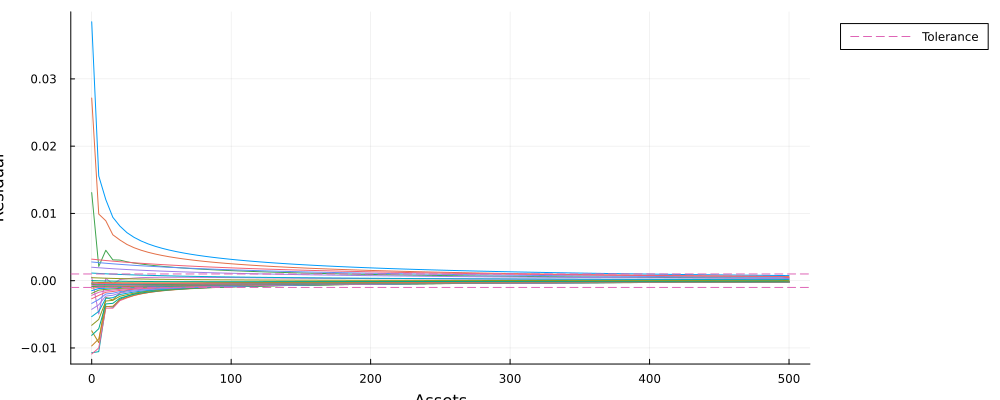

The Euler equation does not everywhere.


In [5]:
# Set up parameters and model
p = BewleyParams(Ny=30, σ=2.0)
m = setup(p, r, CubicSplines())
solve!(p, r, m, tol=1e-3)

# Calculate Euler equation residuals
residuals = zeros(p.Na, p.Ny)
max_residual = 0.0
max_income_level = 0.0
for zy in 1:p.Ny
    y = exp(m.ygrid[zy])
    c = m.policy.c[:, zy]
    a = m.agrid
    a_prime = m.policy.a[:, zy]
    u_prime_c = c.^(-p.σ)
    u_prime_c_prime = [cubic_spline_interpolation(m.agrid, m.policy.c[:, j].^(-p.σ))(a_prime) for j in 1:p.Ny]
    lhs = u_prime_c
    rhs = p.β * (1 + r) .* (m.P[zy, :]' * u_prime_c_prime)
    residuals[:, zy] = lhs - rhs
    current_max_residual = maximum(abs.(residuals[:, zy]))
    if current_max_residual >= 1e-3 && current_max_residual > max_residual
        max_residual = current_max_residual
        max_income_level = m.ygrid[zy]
    end
end

# Plot residuals
plt = plot(xlabel="Assets", ylabel="Residual", legend=:outertopright, size=(1000, 400))
for zy in 1:p.Ny
    plot!(plt, m.agrid, residuals[:, zy], label=false)
end
hline!(plt, [-1e-3, 1e-3], linestyle=:dash, label="Tolerance")
display(plt)

# Check for convergence
converged = all(abs.(residuals) .< 1e-3)
if converged
    println("The Euler equation holds everywhere.")
else
    println("The Euler equation does not everywhere.")
end

As we can see, the Euler equation does not hold everywhere. I put in two horizontal tolerance lines at $+-1e^{-3}$. As the asset level increases, all initial starting incomes, $y$, converge to be within the (somewhat loose) tolerance. This would suggest the following:

$$ As \,\ a \rightarrow \infty\ , \  LHS-RHS \rightarrow 0$$

Otherwise written as:

$$ \log(y') \sim \mathcal{N}(\mu + \rho \log(y), \sigma_{\epsilon}) $$

Which is to say that for high asset levels, the Euler equation holds. This is to be expected as for high asset levels, a any given change in income is unlikely to change their consumption patterns. I.e., If Warren Buffet was to recieve no income next year, this would have (next to, as he doesnt have unlimited money) no effect on his consumption patterns or utility level; equally, should he earn millions more next year, he likely wouldn't spend it.

### Exercise 1b

In [19]:
function simulate(p::BewleyParams, r, m; N = 10_000, T = 1000)
    @unpack agrid, ygrid, policy, P = m
    # mc = rouwenhorst(p.Ny, p.ρ, p.σϵ)
    a  = ones(N) * mean(extrema(agrid))
    y  = ones(N) * ygrid[div(length(ygrid), 2)]
    Pc = cumsum(P, dims=1)
    
    # To produce them all at once
    # y = reshape(QuantEcon.simulate(m.mc, N * T), N, T)

    â = LinearInterpolation((agrid, ygrid), policy.a)
    ĉ = LinearInterpolation((agrid, ygrid), policy.c)

    for t in 1:T
        Threads.@threads for i in 1:N
            # Step assets forward 
            a′   = â(a[i], y[i])
            a[i] = a′
            
            # Step income forward (random draw from our process)
            z    = rand()
            yi   = searchsortedfirst(ygrid, y[i]) 
            yi′  = @views searchsortedfirst(Pc[:, yi], z)  
            y[i] = ygrid[yi′]
        end
    end

    return (; a, y, c = ĉ.(a, y))
end

simulate (generic function with 1 method)

In [20]:
r = [0.01, 0.02, 0.03, 0.04]
mean_a_values = []
mean_c_values = []

anim = @animate for r_values in r
    m = setup(p, r_values, p.interp_mode)
    solve!(p, r_values, m, tol = 1e-3)
    @time df = simulate(p, r_values, m, T = 1000) |> DataFrame

    sd_a = std(df.a)
    plt1 = histogram(df.a,
        bins = 40,
        xlabel = "Assets",
        ylabel = "Density",
        normed = true,
        title  = "Dist. of \n Assets (\$r = $r_values\$)",
        label  = false,
        xlims  = (0, 60),
        ylims  = (0, 0.4)
    )
    mean_a = mean(df.a)
    push!(mean_a_values, mean_a) 
    vline!(plt1, [mean_a], color=:red, label="\$ Mean = $(round(mean_a, digits=2))\$ \n \$ SD = $(round(sd_a, digits = 2))\$")

    sd_c = std(df.c)
    plt2 = histogram(df.c,
        bins = 40,
        xlabel = "Consumption",
        ylabel = "Density",
        normed = true,
        title  = "Dist. of \n Consumption (\$r = $r_values\$)",
        label  = false,
        xlims  = (0, 25),
        ylims  = (0, 0.4)
    )
    mean_c = mean(df.c)
    push!(mean_c_values, mean_c) 
    vline!(plt2, [mean_c], color=:red, label="\$ Mean = $(round(mean_c, digits=2))\$ \n \$ SD = $(round(sd_c, digits = 2))\$")

    plot(plt1, plt2, layout = (1, 2))
end

  1.060294 seconds (133.07 k allocations: 8.623 MiB, 16.86% compilation time)
  0.851818 seconds (6.06 k allocations: 1.383 MiB)
  0.881589 seconds (6.07 k allocations: 1.383 MiB)
  0.861663 seconds (6.07 k allocations: 1.383 MiB)


Animation("/tmp/jl_PmsgDk", ["000001.png", "000002.png", "000003.png", "000004.png"])

┌ Info: Saved animation to /tmp/jl_r0JYhw3a7a.gif
└ @ Plots /home/vscode/.julia/packages/Plots/a3u1v/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_r0JYhw3a7a.gif")
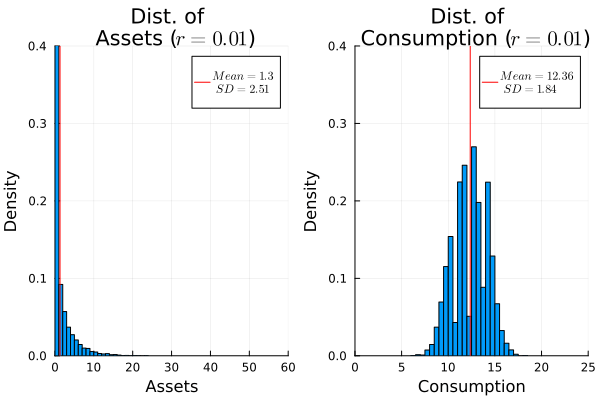

In [21]:
gif(anim, fps = 0.5)

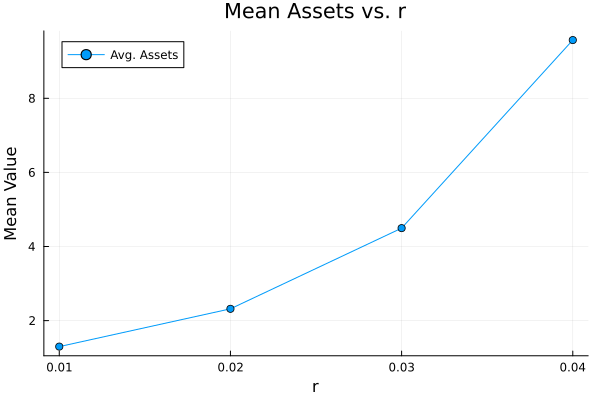

In [ ]:
plot(r, mean_a_values, label="Avg. Assets", xlabel="r", ylabel="Mean Value", marker=:circle, title = "Mean Assets vs. r")

We see from these plots that as the interest rate, r, increases, the average level of assets held by individuals. This is to be expected since the opportunity cost associated with consumption is increased and saving is more beneficial to agents in the economy. We notice that the elasticity of saving is greater than the elasticity of consumption since agents have a lowered incentive to consume due to the higher return on savings. The reason we still see a small increase in consumption is due to the income effect as in our model without borrowing or firms, higher interest rates make individuals essentially richer by giving them a greater return on their assets. We can therefore think of consumption being reduced by the substitution effect, but ultimately increased due to the income effect associated with higher interest rates. 

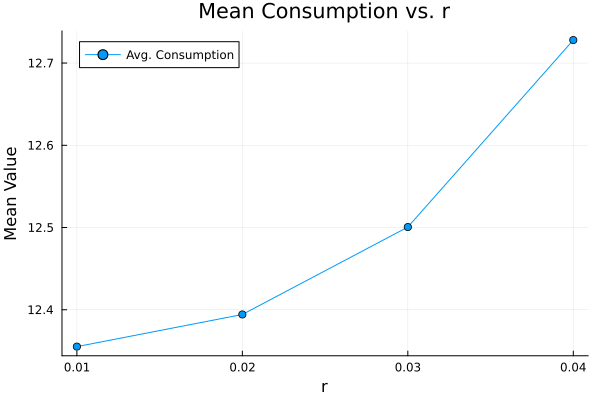

In [26]:
plot(r, mean_c_values, label="Avg. Consumption",  xlabel="r", ylabel="Mean Value", marker=:circle, title = "Mean Consumption vs. r")

### Exercise 1c

To save time in the following, we can presume that the value of r when the mean asset level is 5.1 will fall between 0.03 and 0.04. On sight, we expect it to be much closer to 0.03

In [27]:
r = 0.03
m = setup(p, r, p.interp_mode)
solve!(p, r, m, tol = 1e-1)

r_top = 0.4
r_bot = 0.03
tol = 1e-6
T = 100

for i in 1:100
    r = r_bot + (r_top - r_bot) / 2
    m = setup(p, r, p.interp_mode)
    solve!(p, r, m, tol = 1e-3)
    df = simulate(p, r, m, N = 10_000, T = 10000) |> DataFrame
    mean_a = mean(df.a)
    if abs(5.1 - mean_a) < tol
        break
    elseif mean_a < 5.1
        r_bot = r
    else
        r_top = r
    end
    println("Iteration: ", i, " r: ", r, " mean_a: ", mean_a)
end

println("Final r: ", r)

Iteration: 1 r: 0.050050000000000004 mean_a: 44.53295887687909
Iteration: 2 r: 0.025075 mean_a: 3.2524928089159606
Iteration: 3 r: 0.0375625 mean_a: 7.609818276099439
Iteration: 4 r: 0.03131875 mean_a: 4.840637467492398
Iteration: 5 r: 0.034440625 mean_a: 6.16898687974214
Iteration: 6 r: 0.032879687500000004 mean_a: 5.52550340992161
Iteration: 7 r: 0.032099218750000005 mean_a: 5.120691065124477
Iteration: 8 r: 0.031708984375 mean_a: 4.979520944380277
Iteration: 9 r: 0.0319041015625 mean_a: 5.130474423948712
Iteration: 10 r: 0.031806542968750004 mean_a: 4.9864727214489175
Iteration: 11 r: 0.031855322265625 mean_a: 4.989776336780966
Iteration: 12 r: 0.0318797119140625 mean_a: 5.11303917352196
Iteration: 13 r: 0.03186751708984375 mean_a: 5.072750825376663
Iteration: 14 r: 0.031873614501953126 mean_a: 5.059907320526669
Iteration: 15 r: 0.03187666320800781 mean_a: 5.039940406054565
Iteration: 16 r: 0.03187818756103515 mean_a: 5.088238072865156
Iteration: 17 r: 0.031878949737548824 mean_a: 5

We initially tried to build out own gradient dissent function (which was actually incredibly simple). We soon realised however that in order for this to provide accurate results, we would need to have an incredibly large N and T. I think we also remember hearing something like this in class too. This is becasue of the noise when the number of individuals we are simulating is small (even with just 10,000 as we have) the small variance in noise tilts at some point the gradient dissent to diverge in the wrong direction. This ended up meaning that it took us to 0.0318788..., which we know is wrong, as the minor differences from teh previous value would lead it to swing further away from 5.1. I could have fixed this perhaps by testing on lags too to prevent divergence in the wring direction but as a team we felt givign a root finding fix a go:

In [37]:
function rootfinder(r)
    for i in 1:100
        m = setup(p, r, p.interp_mode)
        solve!(p, r, m)

        avg_assets = 0
        df = simulate(p, r, m, N = 50_000, T = 50_000)
        avg_assets += mean(df.a)

        avg_assets /= 2
        how_close = avg_assets - 5.1
        println("Iteration: ", i, "r = $r: Deviation from 5.1 (error): ", how_close)
        return how_close
    end
end


opt_r = find_zero(rootfinder, (0.03, 0.04); atol = 1e-3)

Iteration: 1r = 0.03: Deviation from 5.1 (error): -2.707768649207435
Iteration: 1r = 0.04: Deviation from 5.1 (error): 11.367538066861739
Iteration: 1r = 0.034374999999999996: Deviation from 5.1 (error): -0.8088592817108156
Iteration: 1r = 0.0371875: Deviation from 5.1 (error): 3.0644609102561198
Iteration: 1r = 0.035781249999999994: Deviation from 5.1 (error): 0.7210407513242982
Iteration: 1r = 0.035078124999999995: Deviation from 5.1 (error): -0.017214155905469042
Iteration: 1r = 0.035429687499999994: Deviation from 5.1 (error): 0.3318453635194061
Iteration: 1r = 0.035253906249999994: Deviation from 5.1 (error): 0.0857716103317605
Iteration: 1r = 0.03516601562499999: Deviation from 5.1 (error): -0.010719850564004041
Iteration: 1r = 0.03520996093749999: Deviation from 5.1 (error): -0.037934047029899
Iteration: 1r = 0.035231933593749994: Deviation from 5.1 (error): 0.052453363156330646
Iteration: 1r = 0.03522094726562499: Deviation from 5.1 (error): 0.039367655441483684
Iteration: 1r =

0.035210316615048184

### Exercise 1d

In the previous exercise, we have solved for r by calculating the value for which our set of households choose an average asset level of 5.1 according to the euler equation, assuming no borrowing within the economy. This is unrealistic since in any developed economy, agents can borrow to smooth consumption. We also haven't included a firm's problem.  In a more realistic scenario, we would choose policy functions which take r as an input and determine consumption and assets, and in which r clears the market for capital which is defined as 
$$K(r) = \int a \,\ d  \Lambda(a,y) = \int \int a \lambda(a,y) \,\ da \,\ dy$$ 
We also wish to achieve stationarity where the distribution of assets is not changing over time. This means that will individual agents vary in their income each period according to the AR(1), the overall distribution of assets and consumption should remain unchanged within our economy. We thus seek to perform a root finding operation which calculates the value of r for which 
$$ED(r) = K(r) - A(\Lambda(r)) = 0$$
This will vary in computational complexity depending on the number of markets we are required to clear, with fewer market clearing conditions leading to a drastically simplified calculation due to the reduced dimensionality of the problem. The difficulty of solving this problem is particularly enhanced when the increased dimensionality leads to non-convex solution paths.  Finding the value of r required to clear markets under these restrictions would be difficult using our previously utilised methods and we would likely have to use a simplfying procedure or a re-parametrization of our constraints. If we were not concerned about computation time, we would also like to abandon any interpolation method and simply calculate the required values for ann infinitely small r. 